# GLM: Hierarchical Linear Regression

(c) 2016 by Danne Elbers, Thomas Wiecki

> This tutorial is adapted from a [blog post by Danne Elbers and Thomas Wiecki called "The Best Of Both Worlds: Hierarchical Linear Regression in PyMC3"](http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/).

Today's blog post is co-written by [Danne Elbers](http://www.linkedin.com/pub/danne-elbers/69/3a2/7ba) who is doing her masters thesis with me on computational psychiatry using Bayesian modeling. This post also borrows heavily from a [Notebook](http://nbviewer.ipython.org/github/fonnesbeck/multilevel_modeling/blob/master/multilevel_modeling.ipynb?create=1) by [Chris Fonnesbeck](http://biostat.mc.vanderbilt.edu/wiki/Main/ChrisFonnesbeck).

The power of Bayesian modelling really clicked for me when I was first introduced to hierarchical modelling. In this blog post we will:
  
  * provide and intuitive explanation of hierarchical/multi-level Bayesian modeling;
  * show how this type of model can easily be built and estimated in [PyMC3](https://github.com/pymc-devs/pymc);
  * demonstrate the advantage of using hierarchical Bayesian modelling, as opposed to non-hierarchical Bayesian modelling by comparing the two
  * visualize the "shrinkage effect" (explained below)
  * highlight connections to the frequentist version of this model.

Having multiple sets of related measurements comes up all the time. In mathematical psychology, for example, you test multiple subjects on the same task. We then want to estimate a computational/mathematical model that describes the behavior on the task by a set of parameters. We could thus fit a model to each subject individually, assuming they share no similarities; or, pool all the data and estimate one model assuming all subjects are identical. Hierarchical modeling allows the best of both worlds by modeling subjects' similarities but also allowing estimation of individual parameters. As an aside, software from our lab, [HDDM](http://ski.cog.brown.edu/hddm_docs/), allows hierarchical Bayesian estimation of a widely used decision making model in psychology. In this blog post, however, we will use a more classical example of [hierarchical linear regression](http://en.wikipedia.org/wiki/Hierarchical_linear_modeling) to predict radon levels in houses.

This is the 3rd blog post on the topic of Bayesian modeling in PyMC3, see here for the previous two:

  * [The Inference Button: Bayesian GLMs made easy with PyMC3](http://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/)
  * [This world is far from Normal(ly distributed): Bayesian Robust Regression in PyMC3](http://twiecki.github.io/blog/2013/08/27/bayesian-glms-2/)  

## The Dataset

Gelman et al.'s (2007) radon dataset is a classic for hierarchical modeling. In this dataset the amount of the radioactive gas radon has been measured among different households in all counties of several states. Radon gas is known to be the highest cause of lung cancer in non-smokers. It is believed to be more strongly present in households containing a basement and to differ in amount present among types of soil.
Here we'll investigate this differences and try to make predictions of radonlevels in different counties based on the county itself and the presence of a basement. In this example we'll look at Minnesota, a state that contains 85 counties in which different measurements are taken, ranging from 2 to 116 measurements per county. 

![radon](https://upload.wikimedia.org/wikipedia/commons/b/b9/CNX_Chem_21_06_RadonExpos.png)

First, we'll load the data: 

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.0


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [3]:
data = pd.read_csv(pm.get_data("radon.csv"))
county_names = data.county.unique()

data["log_radon"] = data["log_radon"].astype(theano.config.floatX)

The relevant part of the data we will model looks as follows:

In [4]:
data[["county", "log_radon", "floor"]].head()

,county,log_radon,floor
0,AITKIN,0.832909,1.0
1,AITKIN,0.832909,0.0
2,AITKIN,1.098612,0.0
3,AITKIN,0.095310,0.0
4,ANOKA,1.163151,0.0


As you can see, we have multiple `radon` measurements (log-converted to be on the real line) -- one row for each house -- in a `county` and whether the house has a basement (`floor` == 0) or not (`floor` == 1). We are interested in whether having a basement increases the `radon` measured in the house. 

## The Models

### Pooling of measurements
Now you might say: "That's easy! I'll just pool all my data and estimate one big regression to assess the influence of a basement across all counties". In math-speak, that model would be:

$$radon_{i, c} = \alpha + \beta*\text{floor}_{i, c} + \epsilon$$ 

Where $i$ represents the measurement, $c$ the county and floor contains a 0 or 1 if the house has a basement or not, respectively. If you need a refresher on Linear Regressions in `PyMC`, check out my [previous blog post](http://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/). Critically, we are only estimating *one* intercept and *one* slope for all measurements over all counties pooled together as illustrated in the graphic below ($\theta$ represents $(\alpha, \beta)$ in our case and $y_i$ are the measurements of the $i$th county).

![pooled](http://f.cl.ly/items/0R1W063h1h0W2M2C0S3M/Screen%20Shot%202013-10-10%20at%208.22.21%20AM.png)

### Unpooled measurements: separate regressions
But what if we are interested in whether different counties actually have different relationships (slope) and different base-rates of radon (intercept)? Then you might say "OK then, I'll just estimate $n$ (number of counties) different regressions -- one for each county". In math-speak that model would be:

$$radon_{i, c} = \alpha_{c} + \beta_{c}*\text{floor}_{i, c} + \epsilon_c$$

Note that we added the subindex $c$ so we are estimating $n$ different $\alpha$s and $\beta$s -- one for each county.

![unpooled](http://f.cl.ly/items/38020n2t2Y2b1p3t0B0e/Screen%20Shot%202013-10-10%20at%208.23.36%20AM.png)

This is the extreme opposite model; where above we assumed all counties are exactly the same, here we are saying that they share no similarities whatsoever. As we show below, this type of model can be very noisy when we have little data per county, as is the case in this data set.

### Partial pooling: Hierarchical Regression aka, the best of both worlds

Fortunately, there is a middle ground to both of these extremes. Specifically, we may assume that while $\alpha$s and $\beta$s are different for each county as in the unpooled case, the coefficients all share similarity. We can model this by assuming that each individual coefficient comes from a common group distribution:

$$\alpha_{c} \sim \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\beta_{c} \sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}^2)$$

We thus assume the intercepts $\alpha$ and slopes $\beta$ to come from a normal distribution centered around their respective group mean $\mu$ with a certain standard deviation $\sigma^2$, the values (or rather posteriors) of which we also estimate. That's why this is called a multilevel, hierarchical or partial-pooling modeling.

![hierarchical](http://f.cl.ly/items/1B3U223i002y3V2W3r0W/Screen%20Shot%202013-10-10%20at%208.25.05%20AM.png)

How do we estimate such a complex model you might ask? Well, that's the beauty of Probabilistic Programming -- we just formulate the model we want and press our [Inference Button(TM)](http://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/). 

(Note that the above is not a complete Bayesian model specification as we haven't defined priors or hyperpriors (i.e. priors for the group distribution, $\mu$ and $\sigma$). These will be used in the model implementation below but only distract here.)

## Probabilistic Programming

### Unpooled/non-hierarchical model

To highlight the effect of the hierarchical linear regression we'll first estimate the non-hierarchical, unpooled Bayesian model from above (separate regressions). For each county we estimate a completely separate mean (intercept). As we have no prior information on what the intercept or regressions could be, we will be using a normal distribution centered around 0 with a wide standard-deviation to describe the intercept and regressions. We'll assume the measurements are normally distributed with noise $\epsilon$ on which we place a uniform distribution.  

In [5]:
coords = {
    "county_idx": data.county_code.values,
    "n_counties": len(data.county.unique()),
    "obs_id": np.arange(len(data.county.unique())),
}

In [6]:
with pm.Model(coords=coords) as unpooled_model:

    # Independent parameters for each county
    county_idx = pm.Data("county_idx", coords["county_idx"])
    obs_id = pm.Data("obs_id", coords["obs_id"])
    a = pm.Normal("a", 0, sigma=100, shape=coords["n_counties"])
    b = pm.Normal("b", 0, sigma=100, shape=coords["n_counties"])

    # Model error
    eps = pm.HalfCauchy("eps", 5)

    # Model prediction of radon level
    # a[county_idx] translates to a[0, 0, 0, 1, 1, ...],
    # we thus link multiple household measures of a county
    # to its coefficients.
    radon_est = a[county_idx] + b[county_idx] * data.floor.values

    # Data likelihood
    y = pm.Normal("y", radon_est, sigma=eps, observed=data.log_radon)

In [7]:
with unpooled_model:
    unpooled_trace = pm.sample(2000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, b, a]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 28 seconds.


In [8]:
unpooled_trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

### Hierarchical Model
Instead of creating models separatley, the hierarchical model creates group parameters that consider the countys not as completely different but as having an underlying similarity. These distributions are subsequently used to influence the distribution of each county's $\alpha$ and $\beta$.

In [9]:
with pm.Model(coords=coords) as hierarchical_model:
    county_idx = pm.Data("county_idx", coords["county_idx"])
    # Hyperpriors for group nodes
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=100)
    sigma_a = pm.HalfNormal("sigma_a", 5.0)
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=100)
    sigma_b = pm.HalfNormal("sigma_b", 5.0)

    # Intercept for each county, distributed around group mean mu_a
    # Above we just set mu and sd to a fixed value while here we
    # plug in a common group distribution for all a and b (which are
    # vectors of length n_counties).
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, shape=coords["n_counties"])
    # Intercept for each county, distributed around group mean mu_a
    b = pm.Normal("b", mu=mu_b, sigma=sigma_b, shape=coords["n_counties"])

    # Model error
    eps = pm.HalfCauchy("eps", 5.0)

    radon_est = a[county_idx] + b[county_idx] * data.floor.values

    # Data likelihood
    radon_like = pm.Normal("radon_like", mu=radon_est, sigma=eps, observed=data.log_radon)

In [10]:
# Inference button (TM)!
with hierarchical_model:
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


Plotting the hierarchical model trace - its found values - from 2000 iterations onwards (right side plot) and its accumulated marginal values (left side plot) 

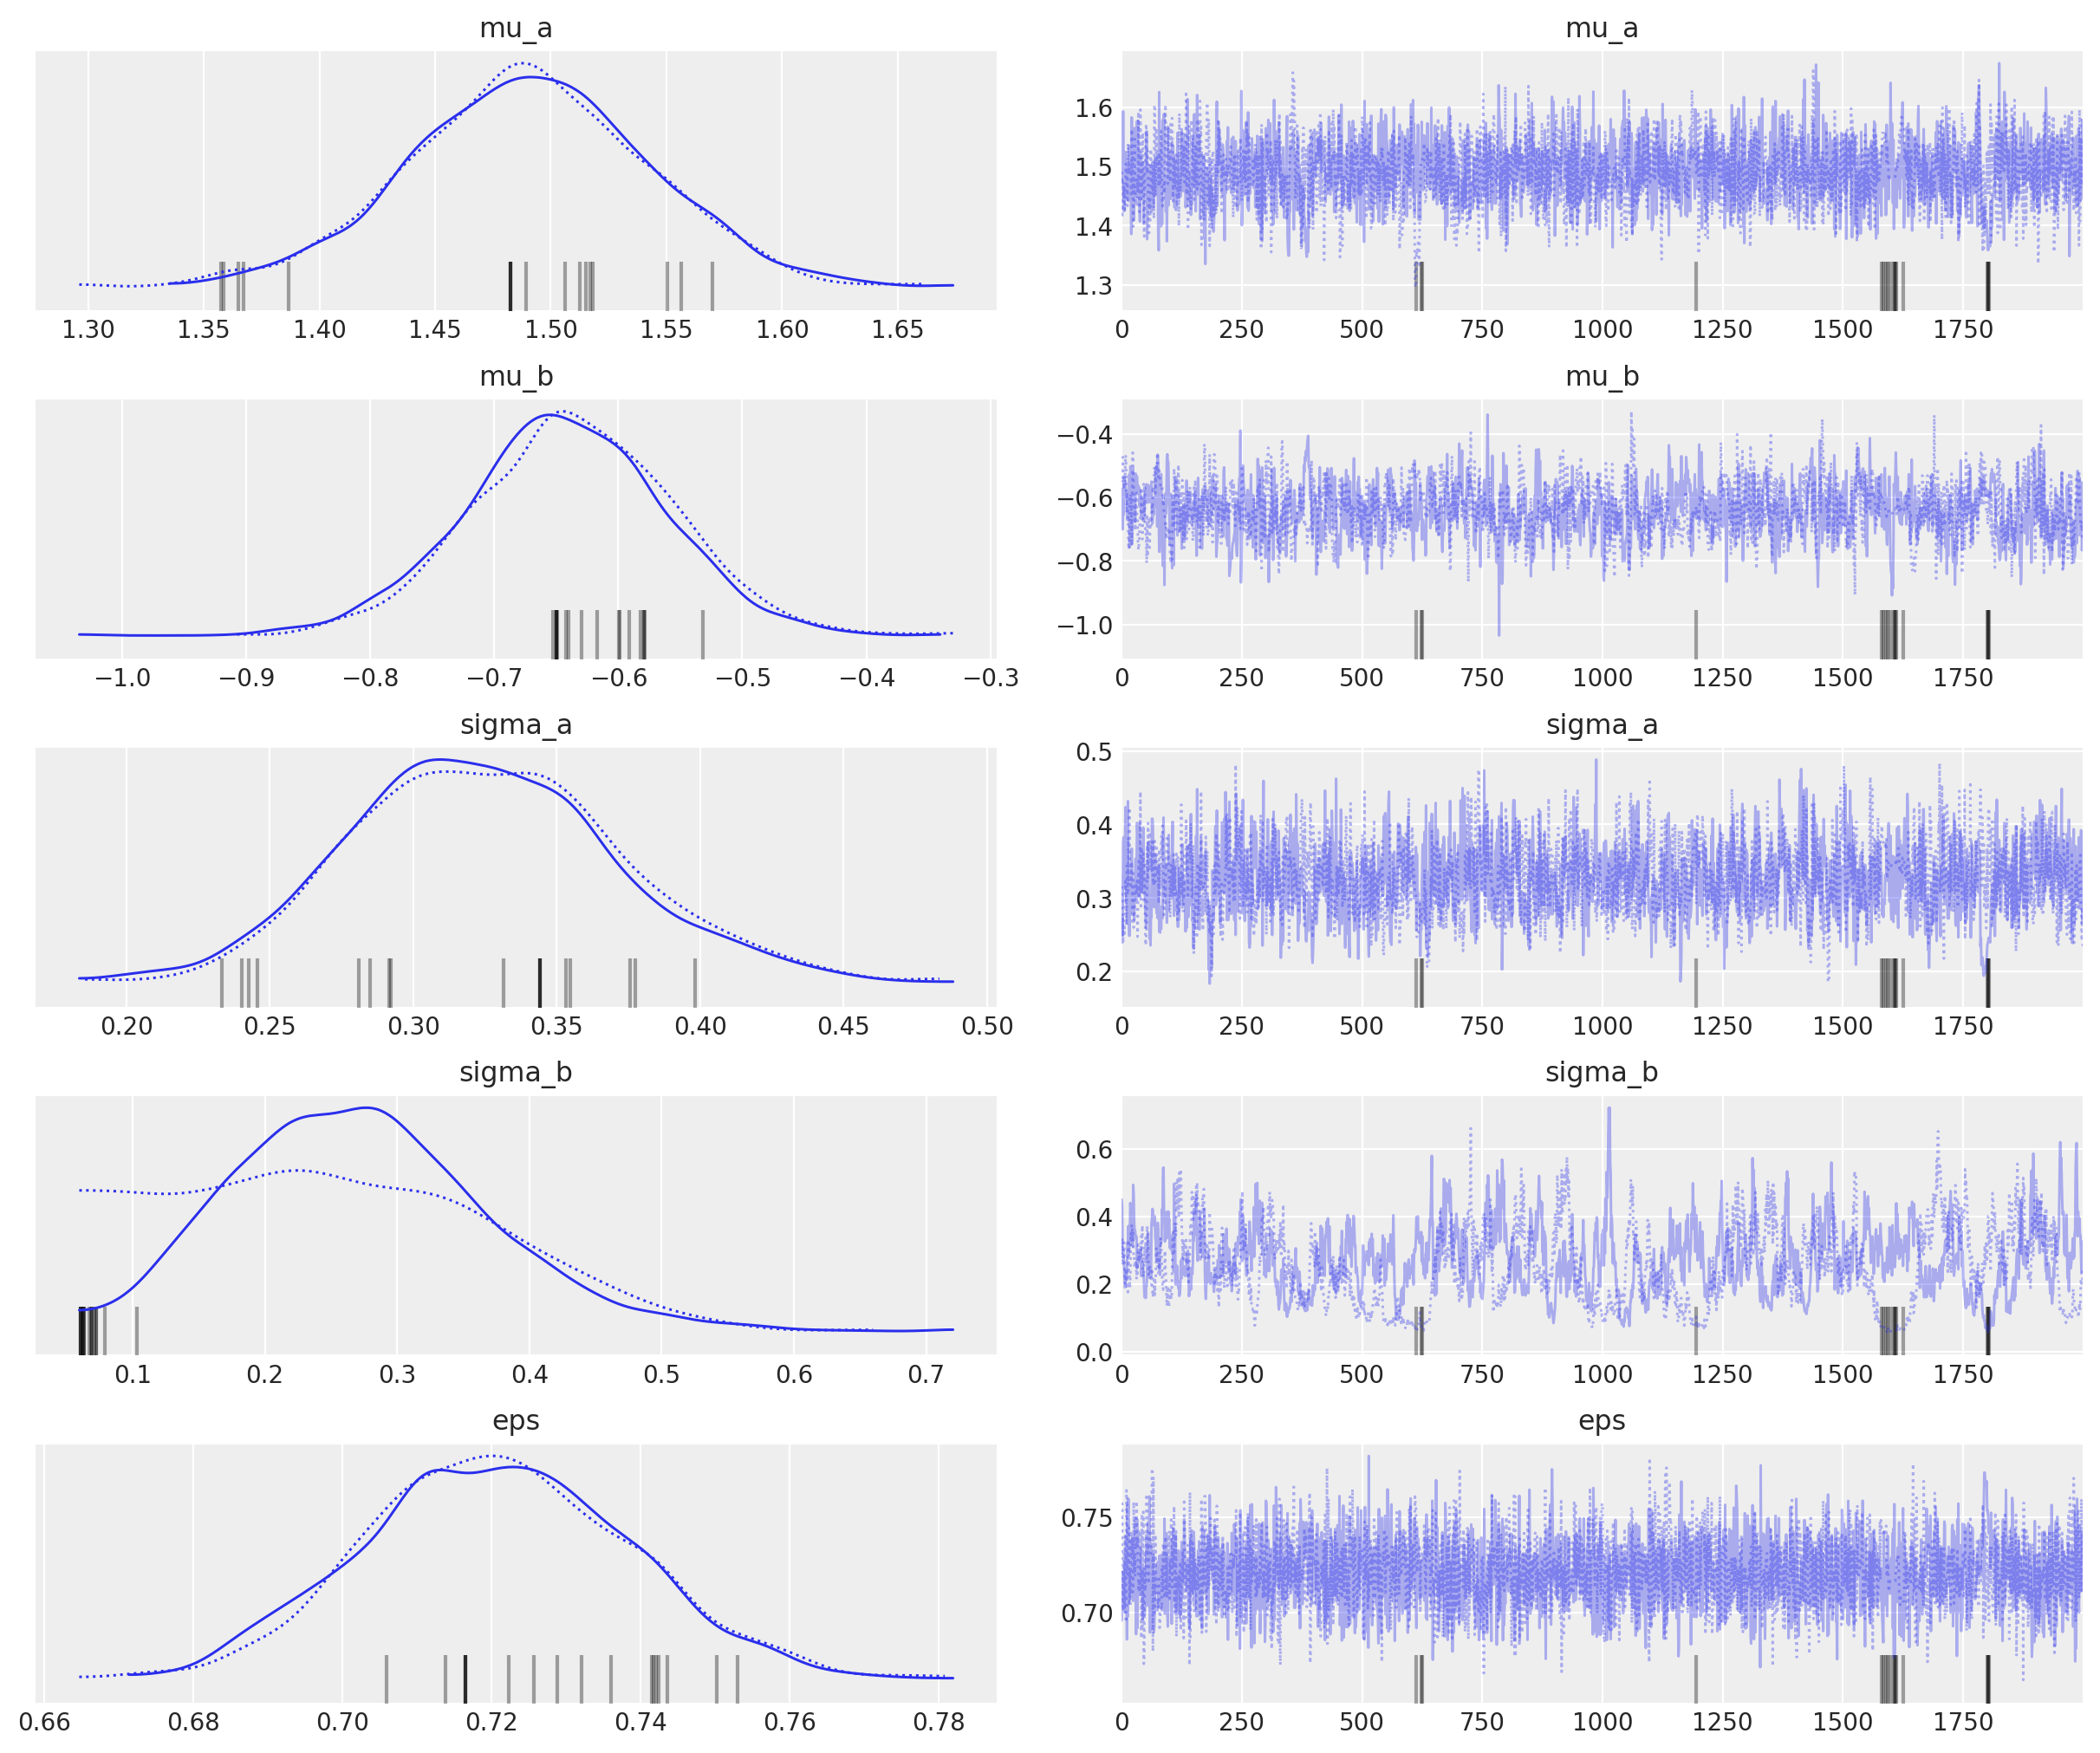

In [11]:
az.plot_trace(hierarchical_trace, var_names=["mu_a", "mu_b", "sigma_a", "sigma_b", "eps"]);

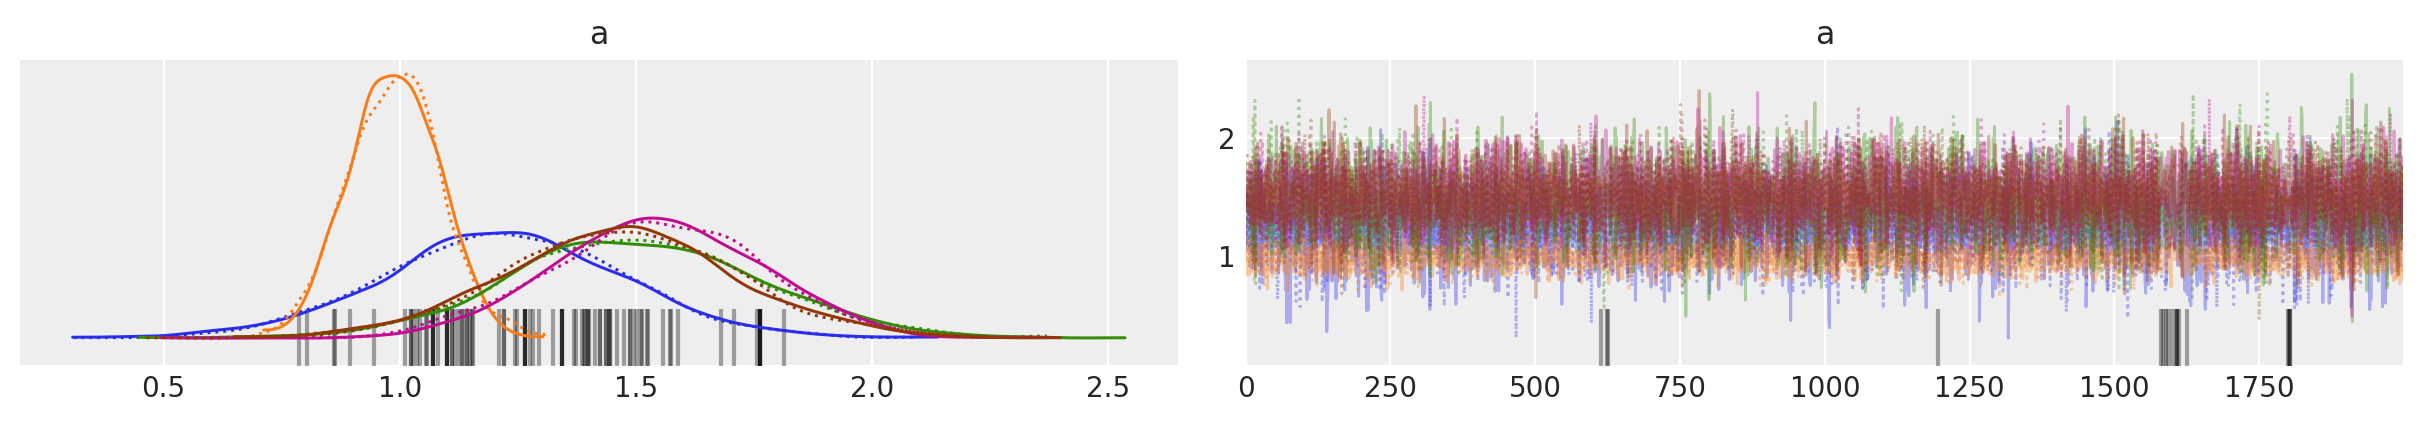

In [12]:
az.plot_trace(hierarchical_trace, var_names=["a"], coords={"a_dim_0": range(5)});

The marginal posteriors in the left column are highly informative. `mu_a` tells us the group mean (log) radon levels. `mu_b` tells us that having no basement decreases radon levels significantly (no mass above zero). We can also see by looking at the marginals for `a` that there is quite some differences in radon levels between counties (each 'rainbow' color corresponds to a single county); the different widths are related to how much confidence we have in each parameter estimate -- the more measurements per county, the higher our confidence will be.

## Posterior Predictive Check

### The Root Mean Square Deviation
To find out which of the models explains the data better we can calculate the Root Mean Square Deviaton (RMSD). This posterior predictive check revolves around recreating the data based on the parameters found at different moments in the chain. The recreated or predicted values are subsequently compared to the real data points, the model that predicts data points closer to the original data is considered the better one. Thus, the lower the RMSD the better.

When computing the RMSD (code not shown) we get the following result:

  * individual/non-hierarchical model: 0.13
  * hierarchical model: 0.08

As can be seen above the hierarchical model performs better than the non-hierarchical model in predicting the radon values. Following this, we'll plot some examples of county's showing the actual radon measurements, the hierarchial predictions and the non-hierarchical predictions. 

/Users/CloudChaoszero/opt/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


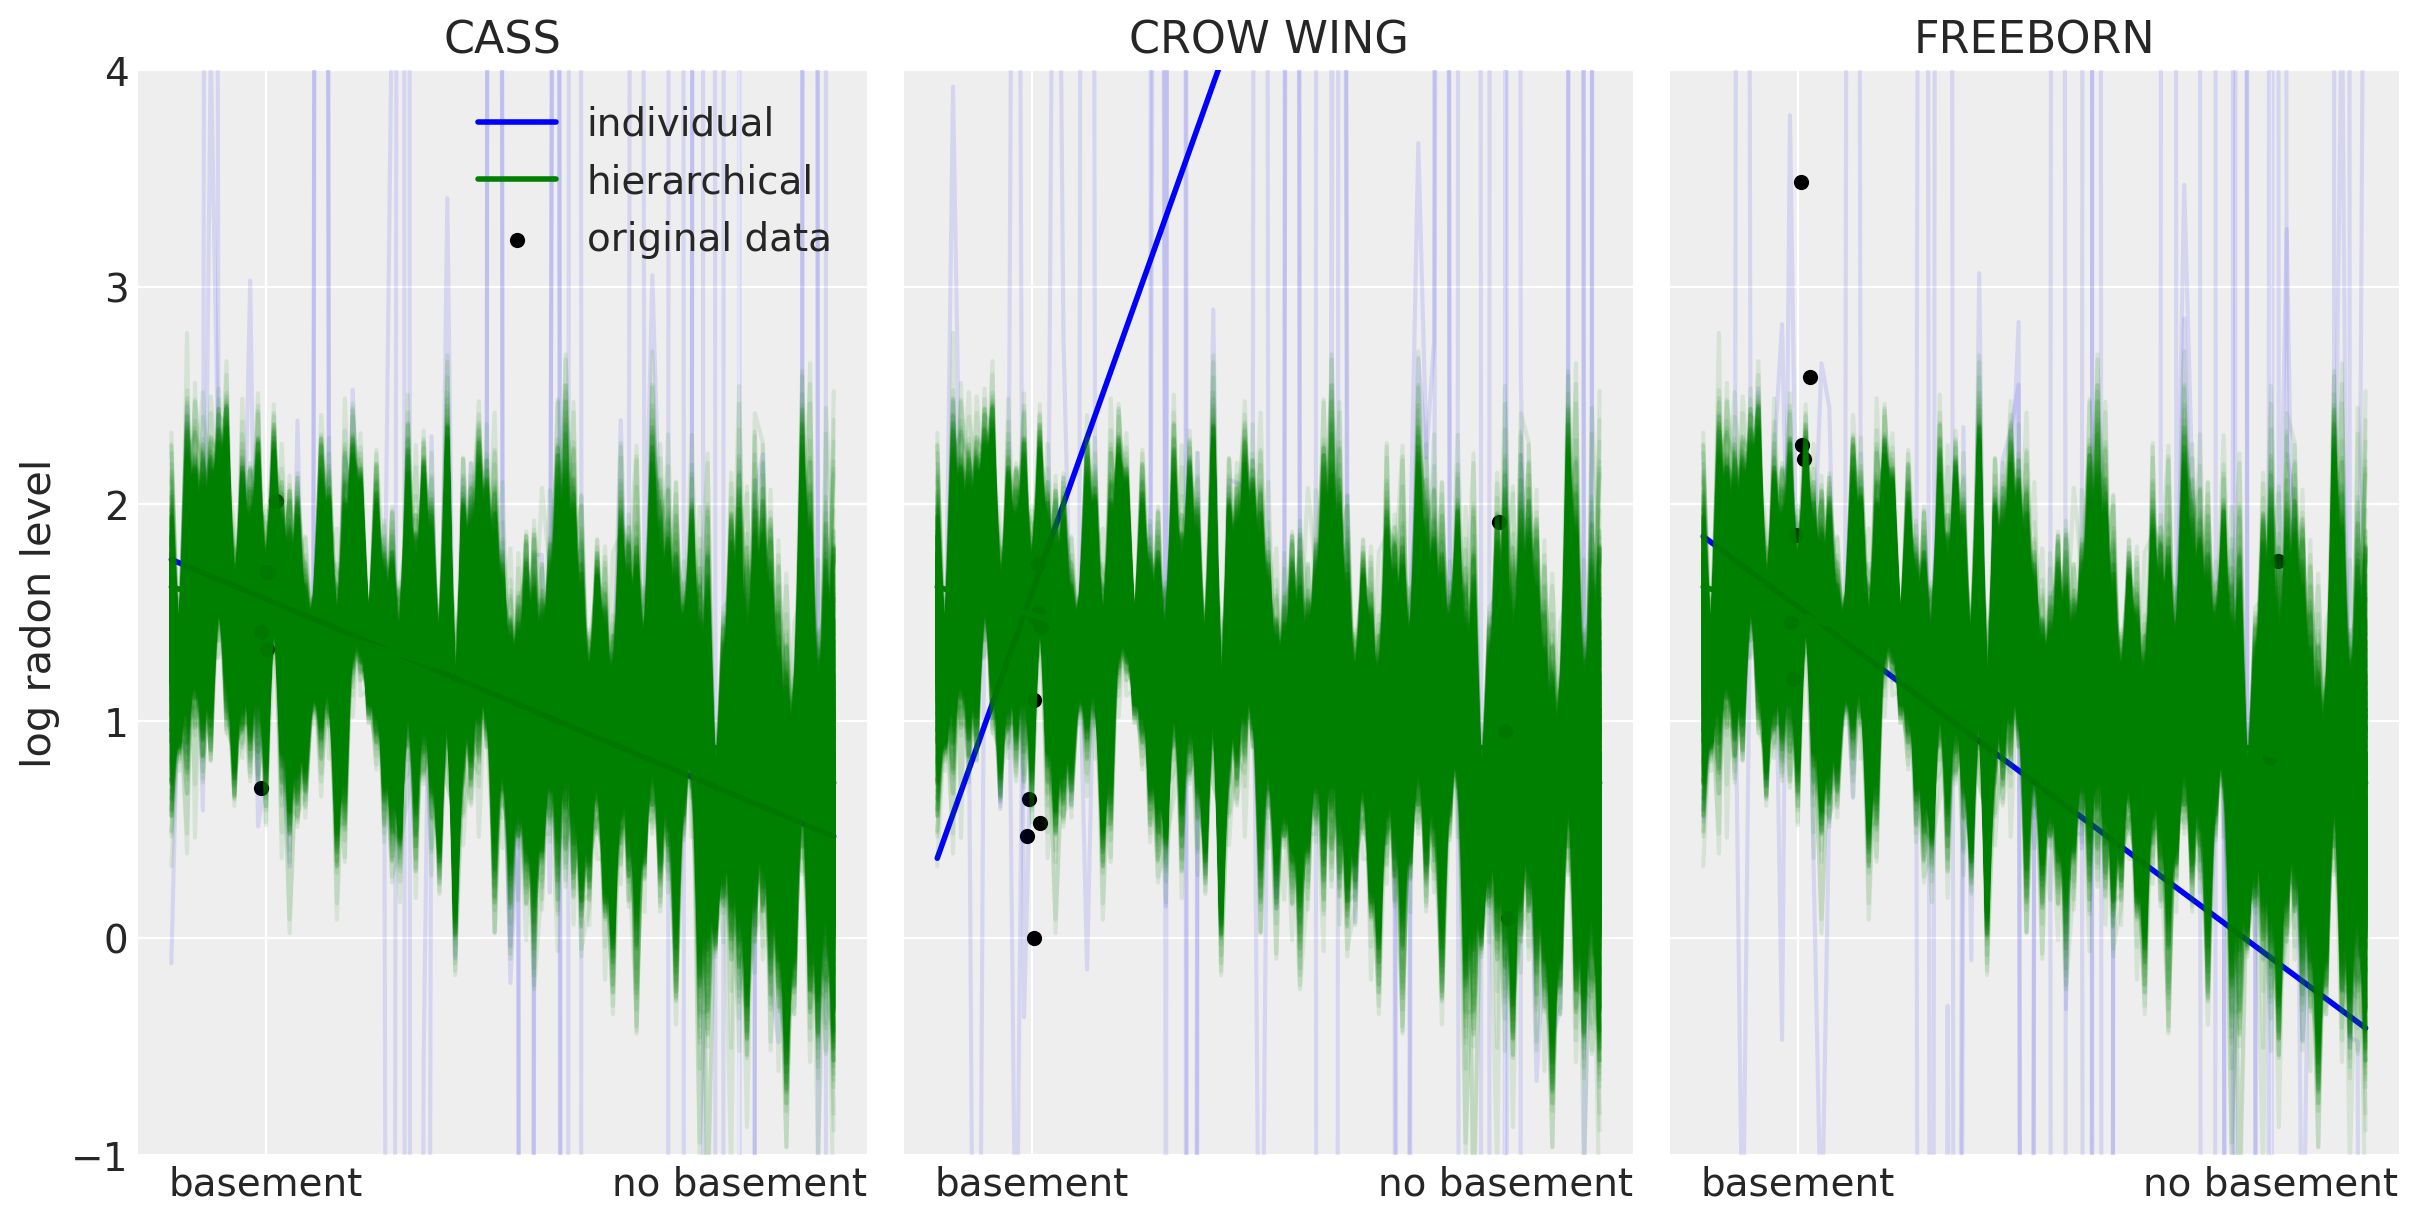

In [14]:
selection = ["CASS", "CROW WING", "FREEBORN"]
fig, axis = plt.subplots(1, 3, figsize=(12, 6), sharey=True, sharex=True)
axis = axis.ravel()
for i, c in enumerate(selection):
    c_data = data[data.county == c]
    c_data = c_data.reset_index(drop=True)
    c_index = np.where(county_names == c)[0][0]
    z = list(c_data["county_code"])[0]

    xvals = np.linspace(-0.2, 1.2, num=85)
    for a_val, b_val in zip(
        unpooled_trace["posterior"]["a"].values[:, c_index],
        unpooled_trace["posterior"]["b"].values[:, c_index],
    ):
        axis[i].plot(xvals, a_val + b_val * xvals, "b", alpha=0.1)
    axis[i].plot(
        xvals,
        unpooled_trace["posterior"]["a"].values[:, c_index].mean()
        + unpooled_trace["posterior"]["b"].values[:, c_index].mean() * xvals,
        "b",
        alpha=1,
        lw=2.0,
        label="individual",
    )
    for a_val, b_val in zip(
        hierarchical_trace["posterior"]["a"].values[0],
        hierarchical_trace["posterior"]["b"].values[0],
    ):
        axis[i].plot(xvals, a_val + b_val * xvals, "g", alpha=0.1)
    axis[i].plot(
        xvals,
        hierarchical_trace["posterior"]["a"].values[0].mean()
        + hierarchical_trace["posterior"]["b"].values[0].mean() * xvals,
        "g",
        alpha=1,
        lw=2.0,
        label="hierarchical",
    )
    axis[i].scatter(
        c_data.floor + np.random.randn(len(c_data)) * 0.01,
        c_data.log_radon,
        alpha=1,
        color="k",
        marker=".",
        s=80,
        label="original data",
    )
    axis[i].set_xticks([0, 1])
    axis[i].set_xticklabels(["basement", "no basement"])
    axis[i].set_ylim(-1, 4)
    axis[i].set_title(c)
    if not i % 3:
        axis[i].legend()
        axis[i].set_ylabel("log radon level")

In the above plot we have the data points in black of three selected counties. The thick lines represent the mean estimate of the regression line of the individual (blue) and hierarchical model (in green). The thinner lines are regression lines of individual samples from the posterior and give us a sense of how variable the estimates are.

When looking at the county 'CASS' we see that the non-hierarchical estimation is strongly biased: as this county's data contains only households with a basement the estimated regression produces the non-sensical result of a giant negative slope meaning that we would expect negative radon levels in a house without basement!

Moreover, in the example county's 'CROW WING' and 'FREEBORN' the non-hierarchical model appears to react more strongly than the hierarchical model to the existance of outliers in the dataset ('CROW WING': no basement upper right. 'FREEBORN': basement upper left). Assuming that there should be a higher amount of radon gas measurable in households with basements opposed to those without, the county 'CROW WING''s non-hierachical model seems off. Having the group-distribution constrain the coefficients we get meaningful estimates in all cases as we apply what we learn from the group to the individuals and vice-versa.

## Shrinkage
Shrinkage describes the process by which our estimates are "pulled" towards the group-mean as a result of the common group distribution -- county-coefficients very far away from the group mean have very low probability under the normality assumption, moving them closer to the group mean gives them higher probability. In the non-hierachical model every county is allowed to differ completely from the others by just using each county's data, resulting in a model more prone to outliers (as shown above). 

In [15]:
hier_a = hierarchical_trace.posterior["a"].mean(("chain", "draw"))
hier_b = hierarchical_trace.posterior["b"].mean(("chain", "draw"))
indv_a = [
    unpooled_trace.posterior["a"][500:, np.where(county_names == c)[0][0]].mean()
    for c in county_names
]
indv_b = [
    unpooled_trace.posterior["b"][500:, np.where(county_names == c)[0][0]].mean()
    for c in county_names
]

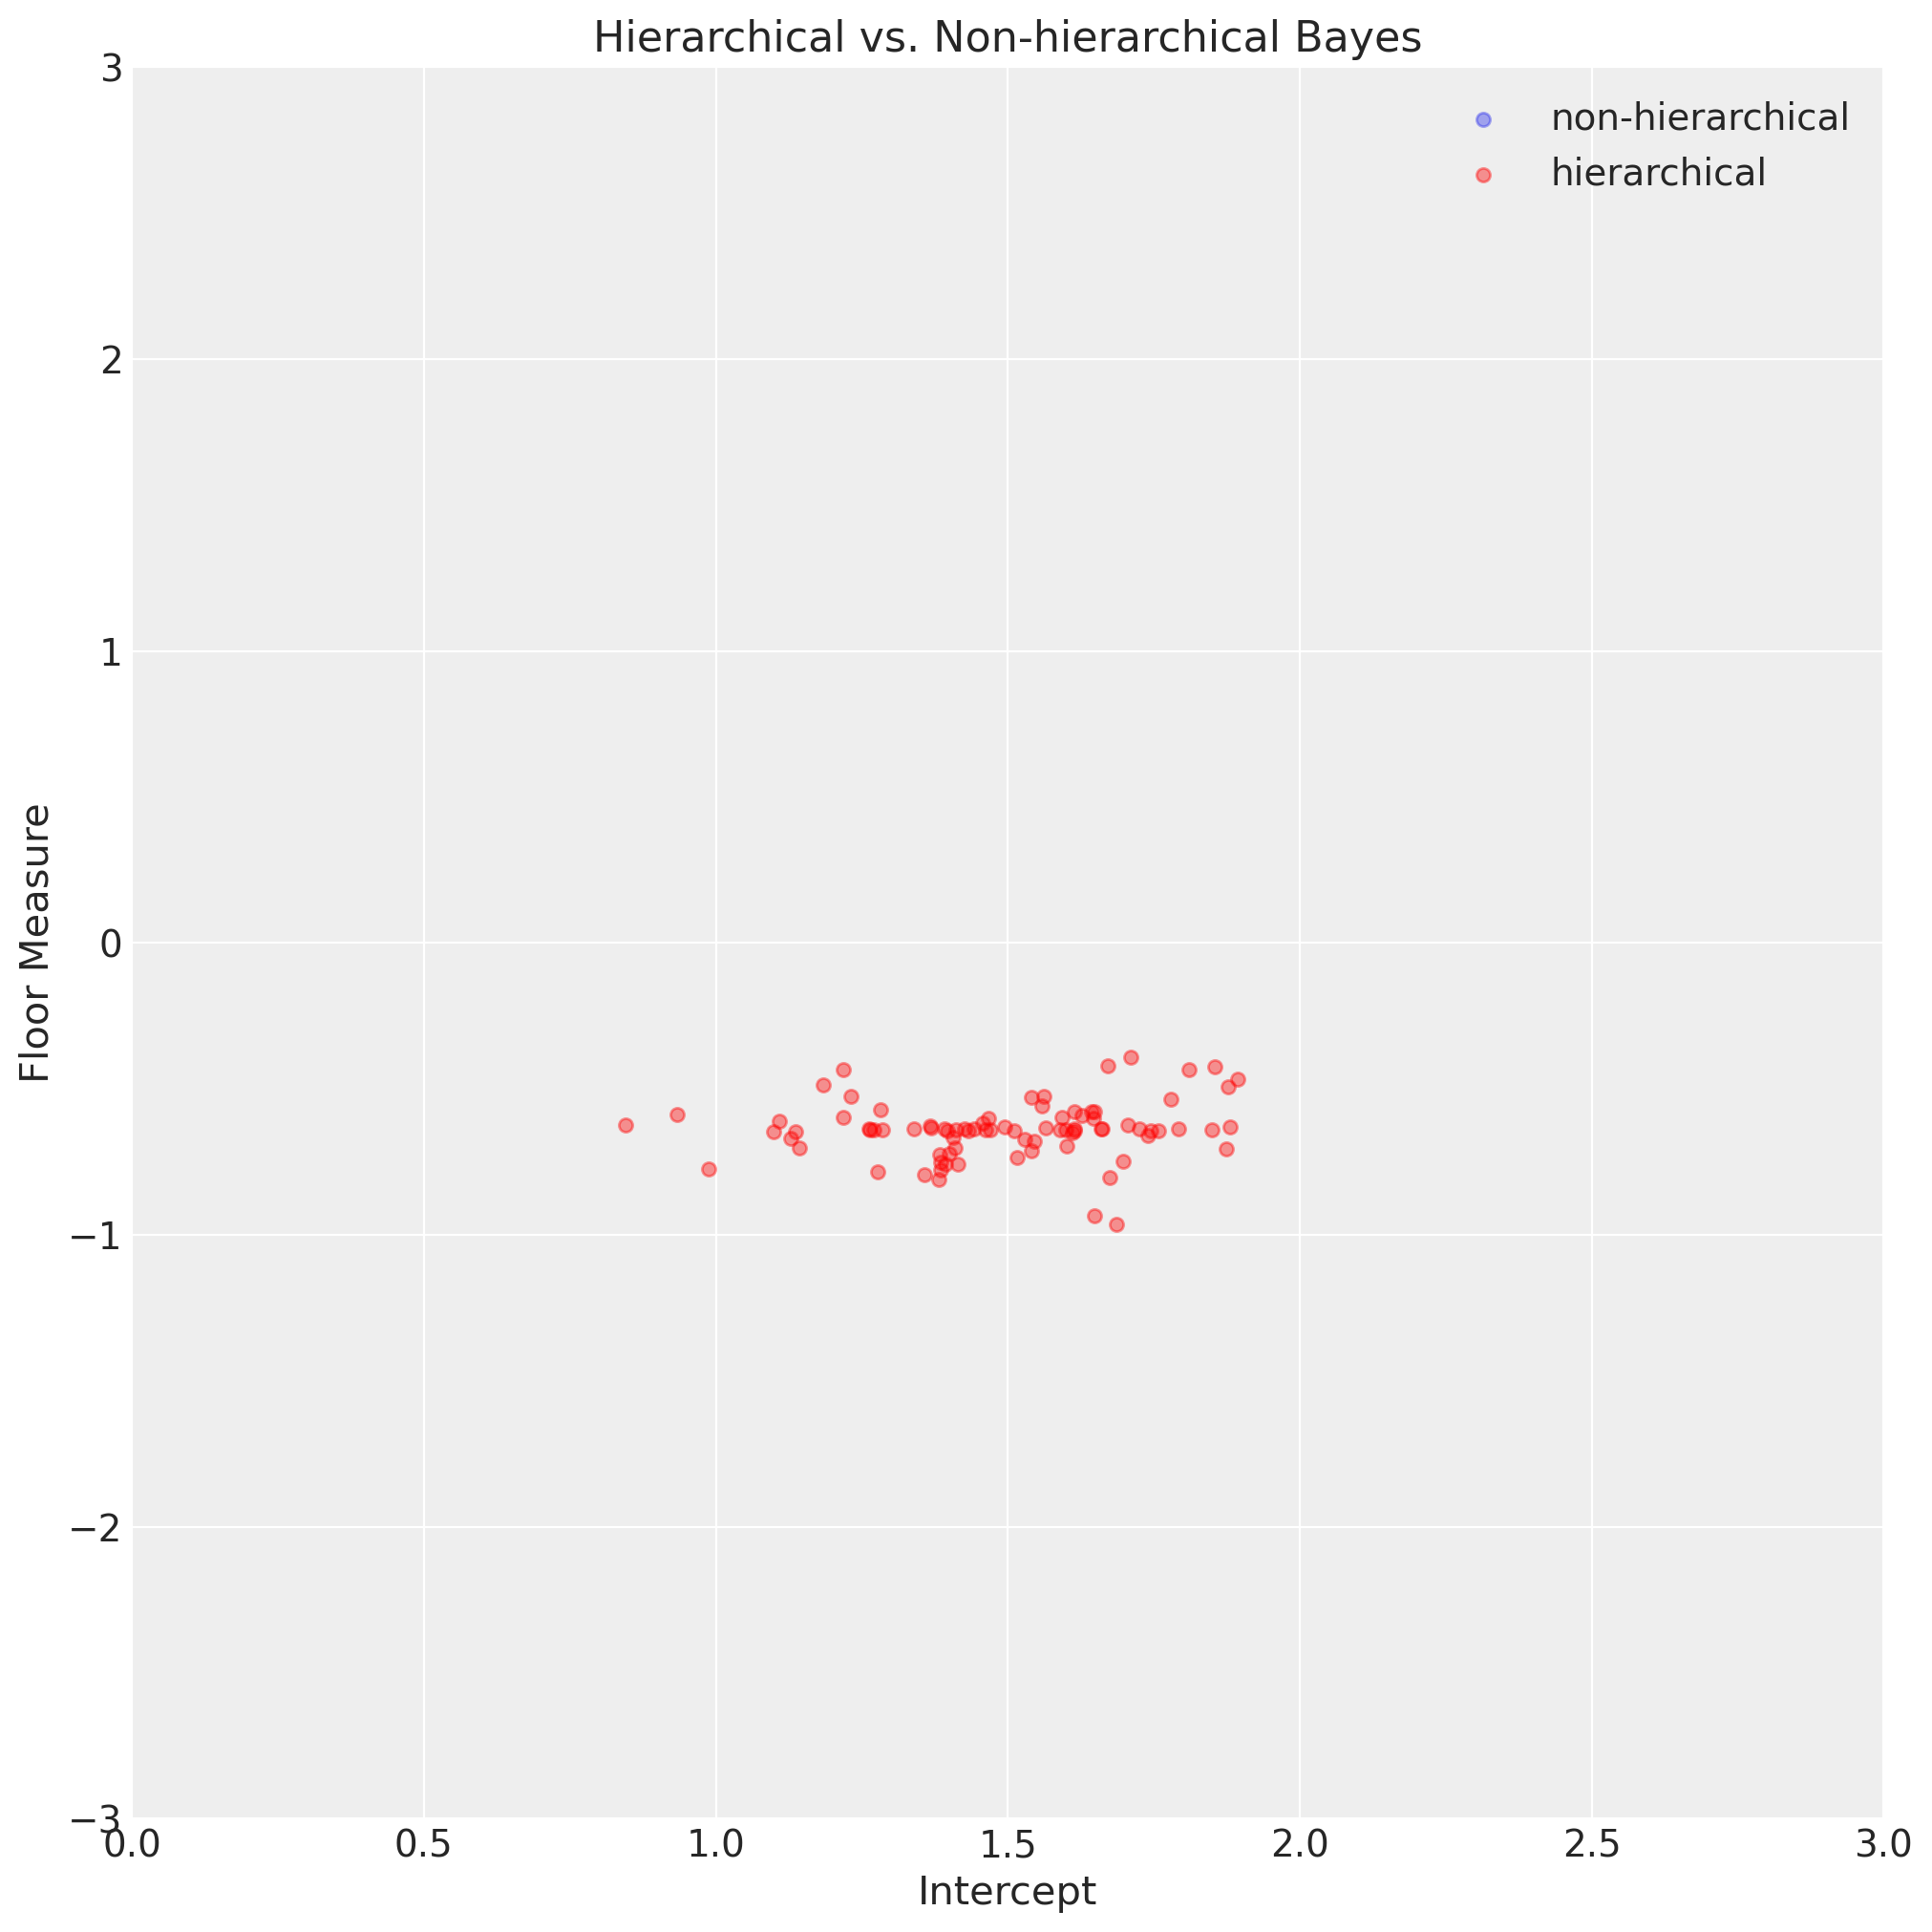

In [16]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(
    111,
    xlabel="Intercept",
    ylabel="Floor Measure",
    title="Hierarchical vs. Non-hierarchical Bayes",
    xlim=(0, 3),
    ylim=(-3, 3),
)

ax.scatter(indv_a, indv_b, s=26, alpha=0.4, label="non-hierarchical")
ax.scatter(hier_a, hier_b, c="red", s=26, alpha=0.4, label="hierarchical")
for i in range(len(indv_b)):
    ax.arrow(
        indv_a[i],
        indv_b[i],
        hier_a[i] - indv_a[i],
        hier_b[i] - indv_b[i],
        fc="k",
        ec="k",
        length_includes_head=True,
        alpha=0.4,
        head_width=0.04,
    )
ax.legend();

In the shrinkage plot above we show the coefficients of each county's non-hierarchical posterior mean (blue) and the hierarchical posterior mean (red). To show the effect of shrinkage on a single coefficient-pair (alpha and beta) we connect the blue and red points belonging to the same county by an arrow. Some non-hierarchical posteriors are so far out that we couldn't display them in this plot (it makes the axes too wide). Interestingly, all hierarchical posteriors of the floor-measure seem to be around -0.6 indicating that having a basement in almost all county's is a clear indicator for heightened radon levels. The intercept (which we take for type of soil) appears to differ among countys. This information would have been difficult to find if we had only used the non-hierarchial model.

Critically, many effects that look quite large and significant in the non-hiearchical model actually turn out to be much smaller when we take the group distribution into account (this point can also well be seen in plot `In[12]` in [Chris' NB](http://nbviewer.ipython.org/github/fonnesbeck/multilevel_modeling/blob/master/multilevel_modeling.ipynb)). Shrinkage can thus be viewed as a form of smart regularization that helps reduce false-positives!

### Connections to Frequentist statistics

This type of hierarchical, partial pooling model is known as a [random effects model](https://en.wikipedia.org/wiki/Random_effects_model) in frequentist terms. Interestingly, if we placed uniform priors on the group mean and variance in the above model, the resulting Bayesian model would be equivalent to a random effects model. One might imagine that the difference between a model with uniform or wide normal hyperpriors should not have a huge impact. However, [Gelman says](http://andrewgelman.com/2014/03/15/problematic-interpretations-confidence-intervals/) encourages use of weakly-informative priors (like we did above) over flat priors.

## Summary

In this post, co-authored by Danne Elbers, we showed how a multi-level hierarchical Bayesian model gives the best of both worlds when we have multiple sets of measurements we expect to have similarity. The naive approach either pools all data together and ignores the individual differences, or treats each set as completely separate leading to noisy estimates, as shown above. By assuming that each individual data set (each county in our case) is distributed according to a group distribution -- which we simultaneously estimate -- we benefit from increased statistical power and smart regularization via the shrinkage effect. Probabilistic Programming in [PyMC3](https://github.com/pymc-devs/pymc3) then makes Bayesian estimation of this model trivial.

As a follow-up we could also include other states into our model. For this we could add yet another layer to the hierarchy where each state is pooled at the country level. Finally, readers of my blog will notice that we didn't use `glm()` here as it does not play nice with hierarchical models yet.

## References
  * [The underlying Notebook of this blog post](https://rawgithub.com/twiecki/WhileMyMCMCGentlySamples/master/content/downloads/notebooks/GLM_hierarchical.ipynb)
  * Blog post: [The Inference Button: Bayesian GLMs made easy with PyMC3](http://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/)
  * Blog post: [This world is far from Normal(ly distributed): Bayesian Robust Regression in PyMC3](http://twiecki.github.io/blog/2013/08/27/bayesian-glms-2/)  
  * [Chris Fonnesbeck repo containing a more extensive analysis](https://github.com/fonnesbeck/multilevel_modeling/)
  * Blog post: [Shrinkage in multi-level hierarchical models](http://doingbayesiandataanalysis.blogspot.com/2012/11/shrinkage-in-multi-level-hierarchical.html) by John Kruschke
  * Gelman, A.; Carlin; Stern; and Rubin, D., 2007, "Replication data for: Bayesian Data Analysis, Second Edition", 
  * Gelman, A., & Hill, J. (2006). [Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.). Cambridge University Press.](http://www.amazon.com/Analysis-Regression-Multilevel-Hierarchical-Models/dp/052168689X)
  * Gelman, A. (2006). Multilevel (Hierarchical) modeling: what it can and cannot do. Technometrics, 48(3), 432–435.
  
### Acknowledgements
Thanks to [Imri Sofer](http://serre-lab.clps.brown.edu/person/imri-sofer/) for feedback and teaching us about the connections to random-effects models and [Dan Dillon](http://cdasr.mclean.harvard.edu/index.php/about-us/current-lab-members/14-faculty/62-daniel-dillon) for useful comments on an earlier draft.

In [17]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri May 14 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

arviz     : 0.11.0
pymc3     : 3.11.0
theano    : 1.1.2
pandas    : 1.2.1
numpy     : 1.20.0
matplotlib: None

Watermark: 2.1.0

